# Desafio Final - IMLDL

Avatar: azambuja - 18/0014153

Avatar: Ferb

# Importação 

In [1]:
#allows the drive to be accessed 
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# tells matplotlib to embed plots within the notebook
%matplotlib inline

# Pytorch
import torch

# random
from random import randint

# modules to dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# modules to adequate the NN
from torch import nn
from torch import optim

# Measuring execution time
import time

from fastai.vision import *
import gc

gc.collect()
torch.cuda.empty_cache()

In [3]:
def testar_gpu():
	train_on_gpu = torch.cuda.is_available() #Observa se a GPU está disponivel
	if train_on_gpu: #Se sim
		device = torch.device('cuda') #Seleciona o device como GPU
		print("Treinando na GPU") #E manda a mensagem
	else: #Se não
		device = torch.device('cpu') #Seleciona o device como cpu
		print("GPU indisponível, treinando na CPU") #E avisa que a GPU não esta disponível
	return device

device = testar_gpu()

Treinando na GPU


# Montagem do Dataset

### **Atenção:** A célula abaixo só vai ser executada durante o processo de montagem do dataset, **não rodar novamente**.
Mudar o nome de ```file``` e ```folder_dest``` de acordo com a classe.

In [ ]:
file = 'pantanal.csv'
folder_dest = 'pantanal/pantanal1'
path = Path('/content/drive/My Drive/IMLDL/Desafios de Programacao/Desafio Final')
dest = path/folder_dest

download_images(path/file, dest, max_pics=200)

# Importação das Imagens

In [4]:
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.Resize((255, 255)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
data = ImageFolder('/content/drive/My Drive/IMLDL/Desafios de Programacao/Desafio Final/labels', transform=transform)
print('Total de imagens no dataset:', len(data))

Total de imagens no dataset: 1970


### Visualizando o dataset

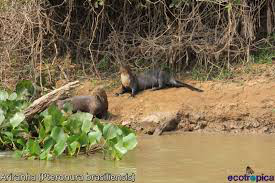

In [5]:
dataVis = ImageList.from_folder('/content/drive/My Drive/IMLDL/Desafios de Programacao/Desafio Final/labels')
dataVis.open(dataVis.items[randint(0,len(dataVis))])

# Transfer Learning:

In [6]:
print('Total de imagens no dataset:', len(data))

# ============== PARAMETRO A SER MODIFICADO =============

percentage = 70

# =======================================================

n_treino = round(len(data)* (percentage/100))

# Os 40% restantes são divididos igualmente (a menos de uma unidade) entre test set e validation set
n_teste = round(len(data)* (100 - percentage)/(2*100)) 
n_valid = len(data) - n_treino - n_teste

print('nº de imagens para treino: {:}'.format(n_treino) +'; nº de imagens para teste: {:}'.format(n_teste) +'; nº de imagens para validação: {:}'.format(n_valid) + '.')
data_train, data_test, data_valid = torch.utils.data.random_split(data, [n_treino, n_teste, n_valid], generator=torch.Generator())

Total de imagens no dataset: 1970
nº de imagens para treino: 1379; nº de imagens para teste: 296; nº de imagens para validação: 295.


In [7]:
# ============== PARAMETROS A SEREM MODIFICADOS =============

batch_size = 20
loader_train, loader_test, loader_valid = DataLoader(data_train, batch_size=batch_size), DataLoader(data_test, batch_size=1), DataLoader(data_valid, batch_size=1)

# =======================================================

### Importação de rede pré-treinada:

In [99]:
def importNN():

    model = models.resnet152(pretrained=True)
    
    for param in model.parameters():
      param.requires_grad = False

    classifier = torch.nn.Sequential(
        torch.nn.Linear(2048, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 10)
    )       
    
    model.fc = classifier

    return model

Define o algoritmo de otimização dos parâmetros da rede e o critério de seleção da saída que será tomada na previsão da classificação da entrada.

In [100]:
def define(model, lr):
    optimizer = optim.SGD(model.fc.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    return optimizer, criterion

Treina os parâmetros da(s) camada(s) "fully connected" da rede contida em 'model' com os exemplos contidos em 'data_train' (organizados por 		'train_loader'). Em seguida, testa a acurácia e o erro de classificação da rede com os exemplos contidos em 'data_test' (organizados por 'loader_test').

In [101]:
def train_test(model, loader_train, loader_test):
  
    train_loss = 0
    test_loss = 0
    acc = 0
    
    model.train()

    # Treino
    for inputs, labels in loader_train:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad() 
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      train_loss += loss
    
    train_loss /= len(loader_train)

    # Teste
    correct = 0
    total = 0   
    model.eval()

    with torch.no_grad():
      for inputs, labels in loader_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels) 

        _,previsao = torch.max(outputs, dim = 1)
        total += 1

        if previsao == labels: 
          correct += 1
        

      test_loss /= len(loader_test)
      acc = (correct/total)*100       

    return train_loss, test_loss, acc

## Treina:

In [105]:
model = importNN().to(device)

START = time.time()

list_train_loss = []
list_test_loss = []
list_acc = []
time1epoch = 0

# ============== PARAMETROS A SEREM MODIFICADOS =============
  
lr = 0.02
epochs = 10

# ===========================================================

optimizer, criterion = define(model, lr)

for epoch in range(1, epochs+1):
  start = time.time()
  train_loss, test_loss, acc = train_test(model, loader_train, loader_test)
  end = time.time()

  list_train_loss.append(train_loss), list_test_loss.append(test_loss), list_acc.append(acc)

  Time = end - start
  if epoch == 1:
    time1epoch = Time

  if epoch < 10:
    print('Epoch: ', epoch ,' loss: {:.4f}'.format(test_loss.item()), ' Accuracy: {:.2f}'.format(acc), '% Time spent this epoch: {:.2f}'.format(Time), 'seconds.')
  else:
    print('Epoch:', epoch ,' loss: {:.4f}'.format(test_loss.item()), ' Accuracy: {:.2f}'.format(acc), '% Time spent this epoch: {:.2f}'.format(Time), 'seconds.')
END = time.time()

print()
TIME = (END - START) - time1epoch
print('\n Time spent during training, excluding first epoch: {:.2f}'.format(TIME), 'seconds.')		

Epoch:  1  loss: 1.8954  Accuracy: 74.32 % Time spent this epoch: 19.39 seconds.
Epoch:  2  loss: 0.9816  Accuracy: 90.88 % Time spent this epoch: 19.91 seconds.
Epoch:  3  loss: 0.4498  Accuracy: 93.24 % Time spent this epoch: 19.43 seconds.
Epoch:  4  loss: 0.2900  Accuracy: 94.26 % Time spent this epoch: 19.17 seconds.
Epoch:  5  loss: 0.2279  Accuracy: 94.93 % Time spent this epoch: 19.21 seconds.
Epoch:  6  loss: 0.1800  Accuracy: 94.93 % Time spent this epoch: 19.37 seconds.
Epoch:  7  loss: 0.1526  Accuracy: 96.62 % Time spent this epoch: 19.42 seconds.
Epoch:  8  loss: 0.1587  Accuracy: 95.61 % Time spent this epoch: 19.25 seconds.
Epoch:  9  loss: 0.1527  Accuracy: 95.27 % Time spent this epoch: 19.25 seconds.
Epoch: 10  loss: 0.1581  Accuracy: 94.93 % Time spent this epoch: 19.27 seconds.


 Time spent during training, excluding first epoch: 174.27 seconds.


## Checa Acurácia:

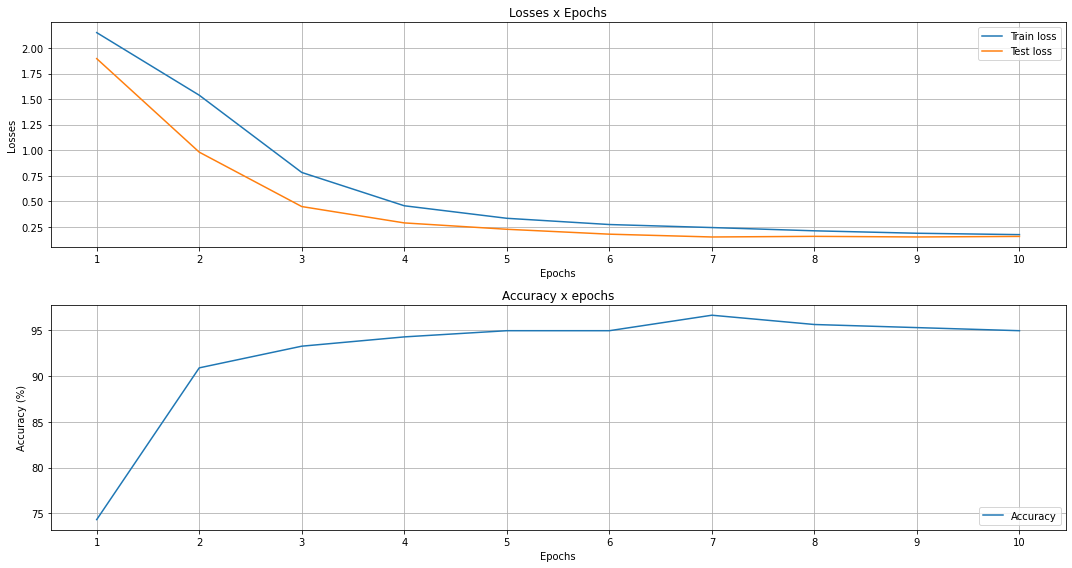

In [106]:
fig, axs = pyplot.subplots(2, figsize=(15,8))
axs[0].plot(range(1, epochs+1), list_train_loss,label="Train loss") #Plota o erro de treino X epocas
axs[0].plot(range(1, epochs+1), list_test_loss, label="Test loss") #Plota o erro de teste x epocas
axs[0].set(xticks=range(1, epochs+1))
axs[0].set_title('Losses x Epochs') #Define o título
axs[0].set(xlabel='Epochs') #Define o nome do eixo x
axs[0].set(ylabel='Losses') #Define o nome do eixo y
axs[0].legend() #Mostra a legenda
axs[0].grid(True) #Mostra a grade


axs[1].plot(range(1, epochs+1), list_acc, label='Accuracy') #Plota a acuracia para erro de 1 graus x epocas
axs[1].set(xticks=range(1, epochs+1))
axs[1].set_title('Accuracy x epochs') #Define o título
axs[1].set(xlabel='Epochs') #Define o nome do eixo x
axs[1].set(ylabel='Accuracy (%)') #Define o nome do eixo y
axs[1].legend(loc='lower right') #Mostra a legenda
axs[1].grid(True) #Mostra a grade

pyplot.tight_layout()

In [107]:
total = 0
correct = 0
loss_valid = 0

for imagem_valid, label_valid in loader_valid:

  loss_v = 0

  imagem_valid, label_valid = imagem_valid.float().to(device), label_valid.to(device)
  outputs_valid = model(imagem_valid)

  _, previsao = torch.max(outputs_valid, dim = 1)
  loss_v = criterion (outputs_valid, label_valid.long())
  total = total + 1 #Adiciona +1 na variável que guarda o total de previsões feitas
  if previsao == label_valid: 
    correct = correct + 1 #Soma +1 na variável que mede quantas previsões dessa categoria (erro absoluto de 2 graus) estão certas
  loss_valid += loss_v

loss_valid = loss_valid/len(loader_valid)
accuracy = (correct/total)*100 #Calcula a acurácia para erro absoluto de 1 grau em porcentagem

print('A acurácia obtida foi de: {:.2f}'.format(accuracy) + '%.')
print()
print('O erro médio obtido foi de: {:.4f}'.format(loss_valid))
print()
print('O tempo gasto durante o treinamento, excluindo a primeira época, foi de: {:.2f}'.format(TIME), 'segundos.')

A acurácia obtida foi de: 93.90%.

O erro médio obtido foi de: 0.2167

O tempo gasto durante o treinamento, excluindo a primeira época, foi de: 174.27 segundos.


### Definir Threshold

In [108]:
# Atribuindo as fotos do pantanal sem animais a uma variável
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.Resize((255, 255)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
threshold_data = ImageFolder('/content/drive/My Drive/IMLDL/Desafios de Programacao/Desafio Final/pantanal', transform=transform)
print('Total de imagens no dataset:', len(threshold_data))

Total de imagens no dataset: 60


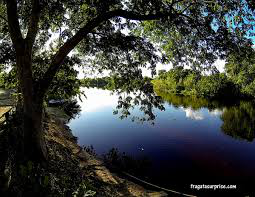

In [109]:
#Visualização de uma foto aleatória do pantanal
threshold_dataVis = ImageList.from_folder('/content/drive/My Drive/IMLDL/Desafios de Programacao/Desafio Final/pantanal')
threshold_dataVis.open(threshold_dataVis.items[randint(0,len(threshold_dataVis))])

In [133]:
#Definindo o Threshold a partir de uma porcentagem da media aritmetica entre as maiores predicoes obtidas nas imagens sem animais
from PIL import Image
from torchvision.transforms import ToTensor
threshold_array = np.zeros((1,len(threshold_data)))
threshold = 0

for i in range(0, len(threshold_data)):
  img, _ = threshold_data.imgs[randint(0,len(threshold_data.imgs)-1)]
  img = Image.open(img)
  image = ToTensor()(img).unsqueeze(0)
  image = image.cuda()

  model.eval()
  output = model(image)

  exps = np.exp(output.data.cpu().numpy())
  exps /= np.sum(exps)
  exps = torch.tensor(exps)

  max_pred, previsao = torch.max(exps, dim = 1)

  threshold_array[0][i] = max_pred


threshold = np.mean(threshold_array)*0.65
print(threshold)


0.2874192753434181


### Teste você mesmo:


In [114]:
def predExtinction(pred):
  animais = ['Onça Pintada', 'Lobo Guará', 'Ariranha', 'Tatu Canastra', 'Tamanduá Bandeira', 'Jacaré do Papo Amarelo', 'Sucuri', 'Tucano', 'Piranha', 'Capivara']
  if (pred >= 0 and pred < 5):
    return 'a', animais[pred]
  elif (pred >= 5 and pred < 10):
    return 'b', animais[pred]
  else:
    return 'c', 'Nenhum'


def predict(img, model, threshold = threshold):
  model.eval()
  output = model(img)

  exps = np.exp(output.data.cpu().numpy())
  exps /= np.sum(exps)
  print(exps, '\n')
  exps = torch.tensor(exps)

  a, previsao = torch.max(exps, dim = 1)
  classe, animal = predExtinction(previsao)

  if (a <= threshold):
    print('Não há na imagem nenhuma espécie listada.')
    previsao, classe = 10, 'c'
  else:
    print('Este animal pertence à classe: ', classe, '. E é o animal ', animal)
  
  return previsao, classe
  

In [115]:
from ipywidgets import widgets

uploader1 = widgets.FileUpload()
print('Faça o upload de uma imagem do Pantanal.')
uploader1

Faça o upload de uma imagem do Pantanal.


FileUpload(value={}, description='Upload')

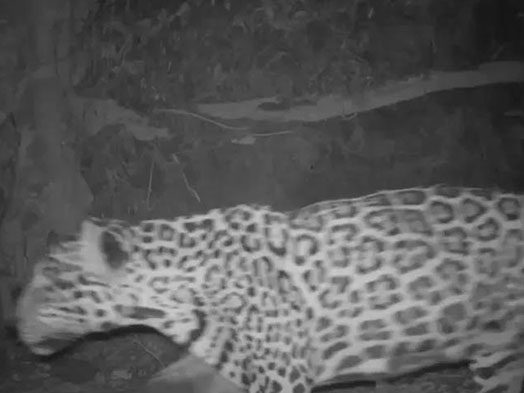

In [130]:
from PIL import Image
import io

img1 = Image.open(io.BytesIO(uploader1.data[0]))
img1

In [131]:
from torchvision.transforms import ToTensor
image = ToTensor()(img1).unsqueeze(0)
image = image.cuda()
predict(image, model)

[[0.306757 0.101055 0.01437  0.138195 0.018824 0.07376  0.013739 0.045388 0.05223  0.235682]] 

Este animal pertence à classe:  a . E é o animal  Onça Pintada


(tensor([0]), 'a')

In [134]:
torch.save(model,'/content/drive/My Drive/IMLDL/Desafios de Programacao/Desafio Final/model.pt')